In [1]:
import cv2
import numpy as np
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

2024-10-06 21:41:48.681382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 21:41:48.698273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 21:41:48.703292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 21:41:48.715450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 21:41:49.593917: W tensorflow/compiler/tf2

In [2]:
minmaxscaler = MinMaxScaler()
model = load_model('lungs_seg.hdf5', compile=False)

I0000 00:00:1728231111.016378    5697 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728231111.060280    5697 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728231111.060618    5697 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728231111.062598    5697 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
image_patch_size = 256
normalized_patched_images = []

image = cv2.imread('xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0145-0001.jpeg', 0)
image = np.array(image)

patched_images = patchify(image, (image_patch_size, image_patch_size), step=image_patch_size)
# patched_images = patched_images[:,:,0,:,:,:]

for i in range(patched_images.shape[0]):
    for j in range(patched_images.shape[1]):
        individual_patched_image = patched_images[i, j, :, :]
        individual_patched_image = minmaxscaler.fit_transform(
                        individual_patched_image.reshape(-1, individual_patched_image.shape[-1])
                    ).reshape(individual_patched_image.shape)
        normalized_patched_images.append(individual_patched_image)

  0%|          | 0/8 [00:00<?, ?it/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


 12%|█▎        | 1/8 [00:01<00:11,  1.64s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 25%|██▌       | 2/8 [00:03<00:09,  1.63s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 38%|███▊      | 3/8 [00:04<00:07,  1.53s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 50%|█████     | 4/8 [00:06<00:05,  1.48s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 62%|██████▎   | 5/8 [00:07<00:04,  1.44s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 75%|███████▌  | 6/8 [00:08<00:02,  1.44s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 88%|████████▊ | 7/8 [00:10<00:01,  1.42s/it]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


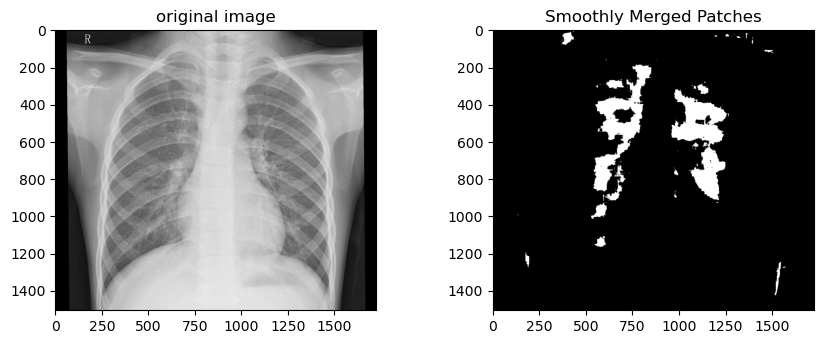

In [8]:
# Reconstruct and predict image using smooth blending
from smooth_tiled_predictions import predict_img_with_smooth_windowing

input_img = minmaxscaler.fit_transform(
                        image.reshape(-1, image.shape[-1])
                    ).reshape(image.shape)

input_img = np.expand_dims(input_img,2)

predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=image_patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=1,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)
predictions_smooth =(predictions_smooth> 0.5)

# final_prediction = (predictions_smooth>0.4).astype(np.uint8)
final_prediction = (predictions_smooth * 255).astype(np.uint8)

# Visualization
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('original image')
plt.imshow(image, cmap="gray")
plt.subplot(232)
plt.title('Smoothly Merged Patches')
plt.imshow(final_prediction, cmap="gray")
plt.show()